# Parametric shape optimization with differentiable FEM simulation


## Setup

In [1]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from utils import (
    MMAOptimizer,
    hex_grid,
    hex_to_pyvista,
    plot_grid,
    plot_grid_slice,
    plot_mesh,
)

from tesseract_jax import apply_tesseract

In [ ]:
# Building the relevant tesseracts

# tesseract_core.build_tesseract("sdf_fd_tess", "latest")
# tesseract_core.build_tesseract("spaceclaim_tess", "latest")
# print("Tesseract built successfully.")

## Design Space

The Mapdl server and the spaceclaim tesseract are both running on a remote machine. Hence we define the host and URLs here.

In [9]:
spaceclaim_host = "172.26.3.35"
mapdl_host = spaceclaim_host

spaceclaim_port = 443
mapdl_port = 50052

spaceclaim_url = f"http://{spaceclaim_host}:{spaceclaim_port}"

In [28]:
design_tess = Tesseract.from_image("sdf_fd_tess")
design_tess.serve()

fem_tess = Tesseract.from_image("pymapdl_tess")
fem_tess.serve()

Lets define the initial parameters.

In [20]:
Nx, Ny, Nz = 128, 128, 4
Lx, Ly, Lz = 50, 40, 2

grid_fin_params = {
    "angular_positions": jnp.array(
        [
            [0, 3.14],
            [0.39, 3.53],
            [0.79, 3.93],
            [1.18, 4.32],
            [1.57, 4.71],
            [1.96, 5.11],
            [2.36, 5.50],
            [2.75, 5.89],
        ]
    ),
    "plane_height": 400,
    "plane_thickness": 100,
    "cuttin_plane_1": 200,
    "cuttin_plane_2": 200,
}

# lets create a flat parameter array from the grid fin params
init_diffable_params = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        grid_fin_params["angular_positions"].flatten(),
    ]
).astype(jnp.float32)

normalization_factors = 1 / jnp.array([1000, 1000] + [3.14 * 2] * 16, dtype=jnp.float32)
normalization_bias = jnp.zeros_like(normalization_factors)


def normalize(params, norms, bias):
    return params * norms + bias


def denormalize(params, norms, bias):
    return (params - bias) / norms


init_diffable_params = normalize(
    init_diffable_params, normalization_factors, normalization_bias
)

non_diffable_paramas = jnp.array(
    [
        grid_fin_params["plane_height"],
        grid_fin_params["plane_thickness"],
    ],
    dtype=jnp.float32,
)

# we define the dict of inputs for the higher order design space tesseract.
# Note that this tesseract takes as an argument the reference to another tesseract under "mesh_tesseract"
design_inputs = {
    "non_differentiable_parameters": non_diffable_paramas,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "static_parameters": [],
    "string_parameters": [
        "F:\\ANSYS Inc\\v242\\scdm\\SpaceClaim.exe",
        "geometry_generation.scscript",
    ],
    "mesh_tesseract": {"type": "url", "ref": spaceclaim_url},
    # the z coordinate of the object is not centered, hence we need to offset the SDF grid origin
    "grid_center": [0.0, 0.0, Lz / 2],
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "scale_mesh": 0.01,
    "max_points": 1000,
    "max_faces": 2000,
    "precompute_jacobian": True,
    "normalize_jacobian": False,
    "sdf_backend": "pyvista",
    "epsilon": 0.001,
}

In [21]:
design_out = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params,
        **design_inputs,
    },
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

Number of vertices: 224
Number of faces: 516


We can visualize the triangular mesh.

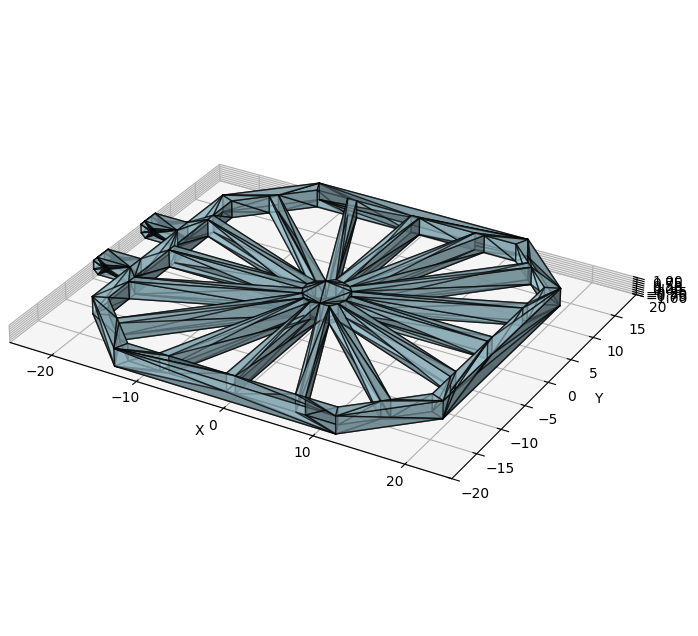

In [22]:
plot_mesh(mesh, [Lx, Ly, Lz])

And the corresponding signed distance field (SDF).

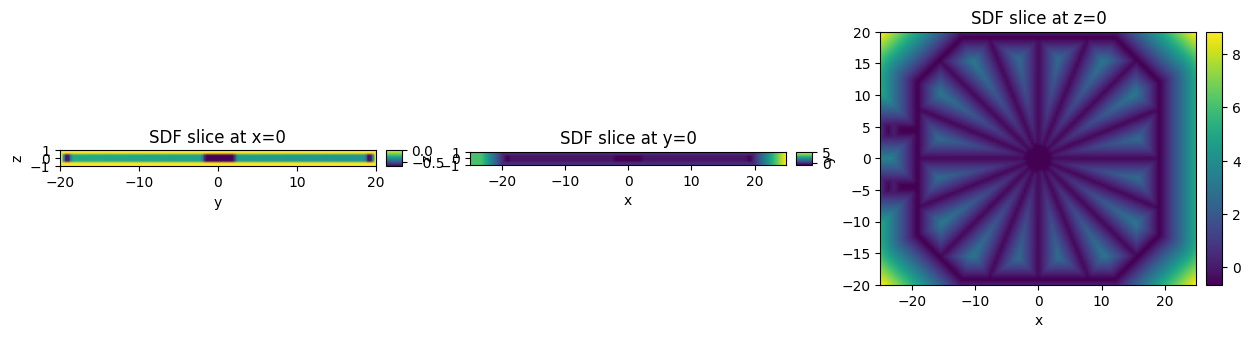

In [23]:
plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz, "SDF")

## Density Variation

To generate a smooth density field from the SDF field, we define a specific function that uses a sigmoid internally.

rho min: 0.0006493852706626058, rho max: 0.8972160220146179


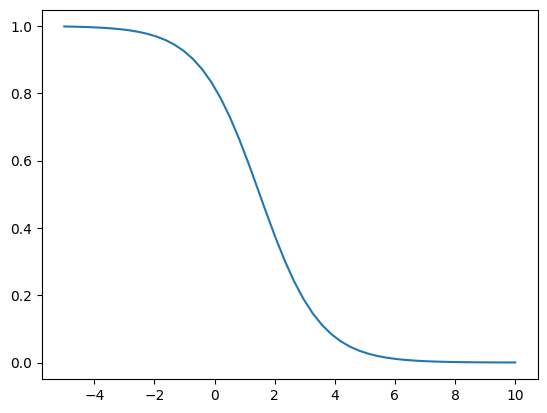

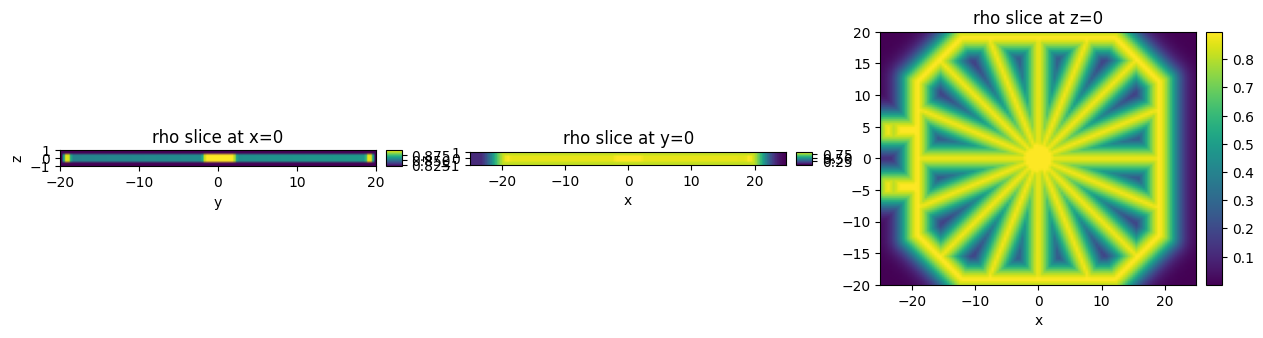

In [24]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 1.0
rho_offset = 1.5

sdfs = jnp.linspace(-5, 10)
rhos = sdf_to_rho(sdfs, scale=rho_scale, offset=rho_offset)

plt.plot(sdfs, rhos)

rho = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

## Hex Mesh

As a next step, we create a hex mesh that is just a regular grid of voxel cells. Each density value is then associated with one cell in the grid.

In [25]:
points, cells = hex_grid(Lx, Ly, Lz, Nx + 1, Ny + 1, Nz + 1)

hex_mesh = {
    "points": points,
    "faces": cells,
    "n_points": jnp.array(points.shape[0]),
    "n_faces": jnp.array(cells.shape[0]),
}

We can look at the density values with a scatter plot.

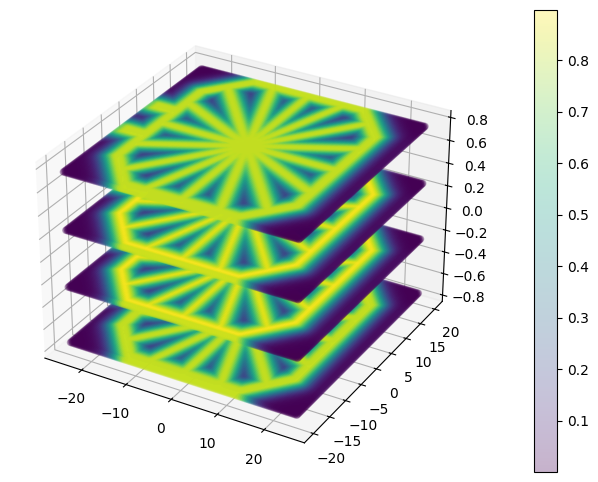

In [26]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = rho.flatten()
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    alpha=0.3,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

## Boundary Conditions

Now its time to define the boundary conditions.

In [ ]:
def get_boundary_masks(mesh: dict, Lx: float, Ly: float, Lz: float, sdf: jnp.ndarray):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Ly: Size of the domain in y-direction.
        Lz: Size of the domain in z-direction.
        sdf: Signed distance field

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = jnp.logical_and(pts[:, 0] <= -Lx / 2 + Lx / 8, sdf.flatten() < 0.5)
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], (Lx / 2) - Lx / 7.6, atol=Lx / 64), sdf.flatten() < 0.5
    )

    return dirichlet_mask, van_neumann_mask


sdf_points = jnp.pad(sdf, [[0, 1], [0, 1], [0, 1]], mode="symmetric")
dirichlet_mask, van_neumann_mask = get_boundary_masks(hex_mesh, Lx, Ly, Lz, sdf_points)

Text(0.5, 0.92, 'Van Neumann Boundary')

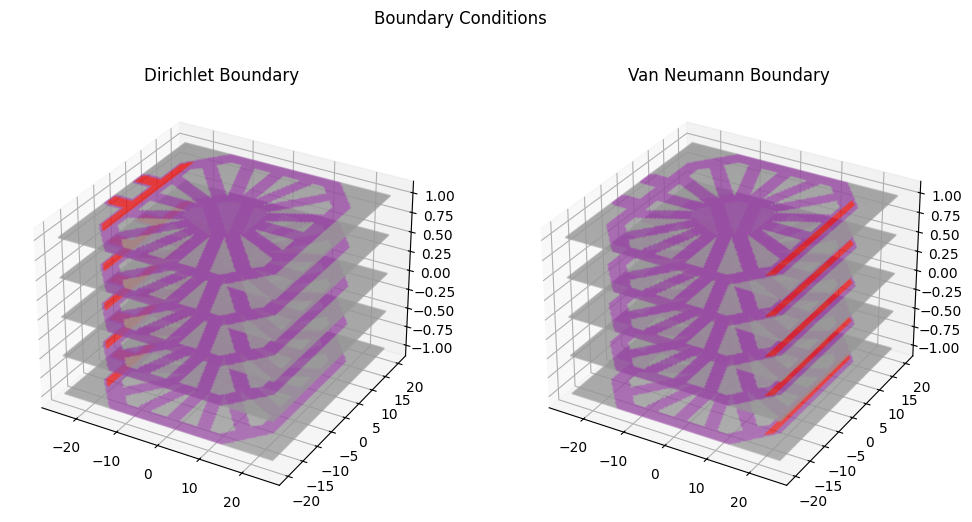

In [ ]:
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))

plt.suptitle("Boundary Conditions")

sdf_points = jnp.pad(sdf, [[0, 1], [0, 1], [0, 1]], mode="symmetric")
base = jnp.where(sdf_points.flatten() < 1, 0.2, 0.4)

pts = hex_mesh["points"][: hex_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: hex_mesh["n_points"]], 0.1, base),
    s=0.7,
    alpha=0.4,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: hex_mesh["n_points"]], 0.1, base),
    s=0.7,
    alpha=0.4,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary")

## Finite Element Analysis

In [164]:
# TODO unify this framework
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

dirichlet_idx = jnp.where(dirichlet_mask)[0]
von_neumann_idx = jnp.where(van_neumann_mask)[0]
von_neumann_values = jnp.array([0, 0.0, 0.1]) / len(von_neumann_idx) + jnp.zeros(
    (von_neumann_idx.shape[0], 3)
)

fem_inputs = {
    "dirichlet_mask": dirichlet_idx,
    "dirichlet_values": jnp.zeros(dirichlet_idx.size),
    "van_neumann_mask": von_neumann_idx,
    "van_neumann_values": von_neumann_values,
    "hex_mesh": hex_mesh,
    "host": str(mapdl_host),
    "port": str(mapdl_port),
    "E0": 1.0,
    "rho_min": 1e-6,
    "log_level": "DEBUG",
    "vtk_output": "mesh_density.vtk",
}

fem_out = apply_tesseract(
    fem_tess,
    {"rho": jnp.expand_dims(rho.flatten(), axis=-1), **fem_inputs},
)


print(f"Compliance: {fem_out['compliance']:.4f}")

Compliance: 21.9814


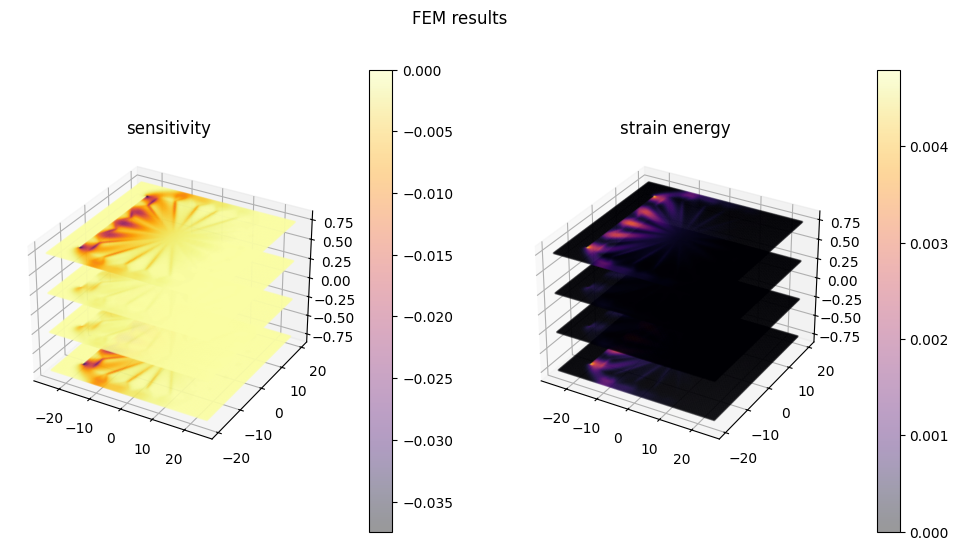

In [165]:
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
plt.suptitle("FEM results")

pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)

scat1 = axs[0].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out["sensitivity"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[0].set_title("sensitivity")
cbar = plt.colorbar(scat1, ax=axs[0], pad=0.1)

scat2 = axs[1].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out["strain_energy"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[1].set_title("strain energy")
cbar = plt.colorbar(scat2, ax=axs[1], pad=0.1)

## Optimization

To be able to track gradients during the optimization process, we add some additional tooling. Basically we define a custom function and its VJP counterparts, where the gradients are stored in a dictionary.

In [166]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [167]:
def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    design_out = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params,
            **design_inputs,
        },
    )

    sdf = design_out["sdf"]
    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)
    rho = identity_and_store_grads(rho, iteration + 2000)

    compliance = apply_tesseract(
        fem_tess,
        {"rho": jnp.expand_dims(rho.flatten(), axis=-1), **fem_inputs},
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    return compliance, {"sdf": sdf, "rho": rho, "surface_mesh": surface_mesh}


grad_fn = jax.value_and_grad(loss, has_aux=True)

By evaluating the loss, we look at the gradients at different stages of the workflow.

In [160]:
(loss_value, aux), grads = grad_fn(init_diffable_params, iteration=0)
print(f"loss {loss_value}, grads {grads}")

Storing values in hash 2000
Storing values in hash 1000
loss 7281.1279296875, grads [ 3331.4272     141.71373    602.3619    1817.7961      97.813446
 -4681.99      -555.2947    4560.392     -997.3253    4404.9854
 -1911.7847     998.66327  -6298.4033    1093.4568   -8070.2334
  -167.04018   5195.3354     -16.425987]


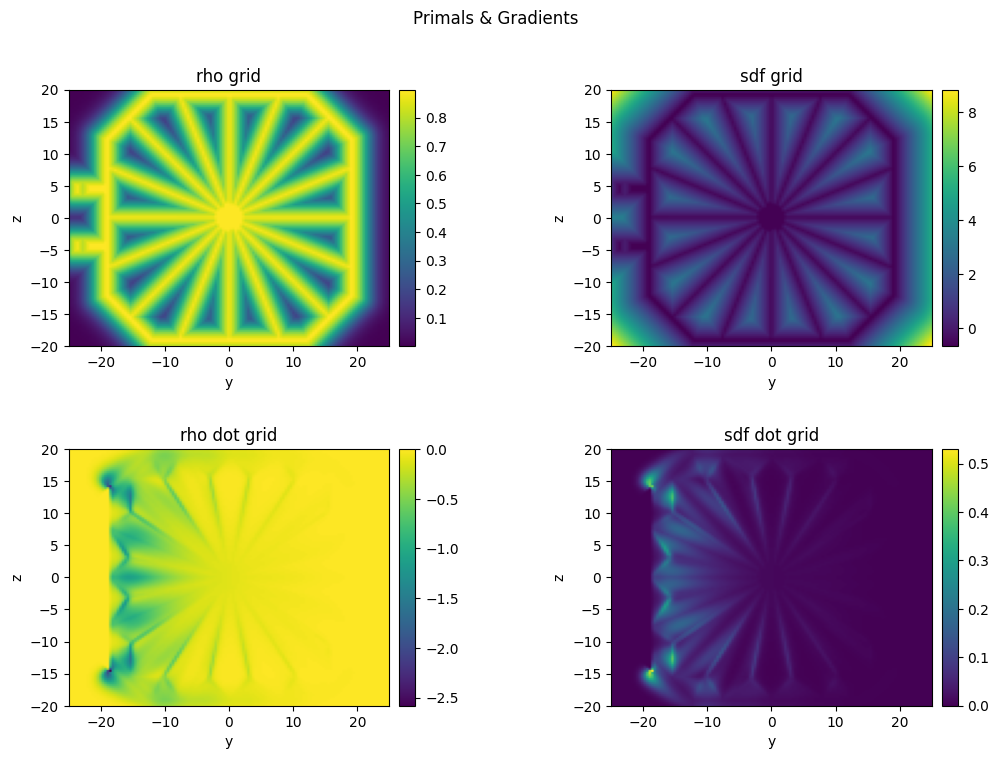

In [163]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
plt.suptitle("Primals & Gradients")

mesh = hex_mesh

pts_coords = mesh["points"]
hex_cells = mesh["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

plot_grid_slice(
    aux["rho"][..., Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 0],
    title="rho grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    grad_storage[2000][1][..., Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 0],
    title="rho dot grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    aux["sdf"][..., Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="sdf grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    grad_storage[1000][1][..., Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="sdf dot grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.0, hspace=0.4)

### Finite difference check

In [168]:
# params = initial_params.copy()

# (loss_value, aux), grads = grad_fn(params, iteration=0)

# # Finite difference check
# run_central_difference = False
# num_tests = 3
# FD_delta = 1.0e-4
# FD_grads = 0 * jnp.array(grads)
# for i in range(num_tests):
#     print(i)
#     params_up = params.at[i].add(FD_delta)
#     (fupp, _), _ = grad_fn(params_up, iteration=i * 2)

#     if run_central_difference:
#         params_down = params.at[i].subtract(2.0 * FD_delta)
#         (fdown, _), _ = grad_fn(params_down, iteration=i * 2 + 1)
#         FD_grads = FD_grads.at[i].set((fupp - fdown) / FD_delta / 2.0)

#     else:
#         FD_grads = FD_grads.at[i].set((fupp - loss_value) / FD_delta)

# if num_tests > 0:
#     sens = jnp.array(grads[0:num_tests])
#     FD_sens = FD_grads[0:num_tests]
#     print(sens)
#     print(FD_sens)
#     errors = sens - FD_sens
#     print(errors)
#     rel_abs_error = jnp.abs(errors / sens)
#     if run_central_difference:
#         print(f"Relative error should be near O({FD_delta})")
#     else:
#         print(f"Relative error should be O({FD_delta * 10})")
#     print(rel_abs_error)

## Design Optimization using MMA

In [169]:
n_steps = 5

param_min = jnp.ones_like(init_diffable_params)[:, None] * -1
param_max = jnp.ones_like(init_diffable_params)[:, None] * 2

# A placeholder is used for constraint
num_constraints = 0
g = jnp.zeros((0, 1))
dgdx = jnp.zeros((0, init_diffable_params.shape[0]))

# initialize the optimizer
x_update_limit = 0.005
params = init_diffable_params.copy()
loss_hist = []
params_hist = []
aux_hist = []
optimizer = MMAOptimizer(
    init_diffable_params[:, None],
    param_min,
    param_max,
    num_constraints,
    x_update_limit=x_update_limit,
)


for i in range(n_steps):
    (loss_value, aux), grads = grad_fn(params, iteration=i)
    print(loss_value)
    print(params)
    print(grads)
    np_params = optimizer.calculate_next_x(loss_value, grads, g, dgdx, i + 1, params)
    params = jnp.array(np_params.flatten())

    loss_hist.append(loss_value)
    params_hist.append(params)
    aux_hist.append(aux)

    print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

Storing values in hash 2000
Storing values in hash 1000
21.981426
[0.2        0.2        0.         0.49999997 0.0621019  0.56210184
 0.12579617 0.62579614 0.18789807 0.68789804 0.24999999 0.74999994
 0.3121019  0.81369424 0.37579614 0.8757961  0.43789804 0.937898  ]
[ 10.057413     0.42782968   1.8185059    5.487848     0.29529166
 -14.134742    -1.6764092   13.767615    -3.0108886   13.29847
  -5.771594     3.014929   -19.014662     3.301108   -24.363731
  -0.5042856   15.6845045   -0.04958919]
Iteration 1, Loss: 21.9814
Storing values in hash 2001
Storing values in hash 1001
22.104416
[ 0.185       0.18500006 -0.01499999  0.48499998  0.04710198  0.5771018
  0.14079615  0.61079615  0.20289807  0.67289805  0.265       0.73499995
  0.3271019   0.79869425  0.39079612  0.890796    0.42289805  0.9528975 ]
[  7.043485    -2.4645603    0.59796035  -4.314228   -14.502065
  44.066185     9.664983   -37.069695    -4.50873     26.400993
 -10.499389     7.31028    -19.265965   -10.420067    26.1

JaxRuntimeError: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/anaconda/envs/fem/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 758, in start
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 683, in run_forever
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once
  File "/anaconda/envs/fem/lib/python3.13/asyncio/events.py", line 89, in _run
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 701, in shell_main
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 469, in dispatch_shell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 379, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 899, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 471, in do_execute
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 632, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
  File "/tmp/ipykernel_64507/1662339227.py", line 27, in <module>
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 502, in value_and_grad_f
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 2194, in _vjp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 315, in vjp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 287, in linearize
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 255, in direct_linearize
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 212, in call_wrapped
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api_util.py", line 106, in flatten_fun_nokwargs2
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api_util.py", line 292, in _argnums_partial
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 421, in _get_result_paths_thunk
  File "/tmp/ipykernel_64507/774747035.py", line 15, in loss
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 384, in apply_tesseract
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 924, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 1135, in fallback_linearize_rule
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 1169, in linearize_from_jvp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 212, in call_wrapped
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/linear_util.py", line 421, in _get_result_paths_thunk
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 126, in tesseract_dispatch_jvp_rule
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/partial_eval.py", line 224, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/partial_eval.py", line 233, in default_process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 1189, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/dispatch.py", line 94, in apply_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 263, in cache_miss
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 146, in _python_pjit_helper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 1622, in _pjit_call_impl_python
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/profiler.py", line 359, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/pxla.py", line 1371, in __call__
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/callback.py", line 784, in _wrapped_callback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 208, in _dispatch
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/tesseract_compat.py", line 160, in apply
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 35, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 325, in apply
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 619, in run_tesseract
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 539, in _request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/api.py", line 59, in request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/sessions.py", line 589, in request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/sessions.py", line 703, in send
  File "/anaconda/envs/fem/lib/python3.13/site-packages/requests/adapters.py", line 708, in send
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connectionpool.py", line 864, in urlopen
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connectionpool.py", line 535, in _make_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/urllib3/connection.py", line 565, in getresponse
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 1447, in getresponse
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 331, in begin
  File "/anaconda/envs/fem/lib/python3.13/http/client.py", line 292, in _read_status
  File "/anaconda/envs/fem/lib/python3.13/socket.py", line 723, in readinto
KeyboardInterrupt: 

### Optimization Postprocess

Text(0.5, 1.0, 'Compliance over Optimization')

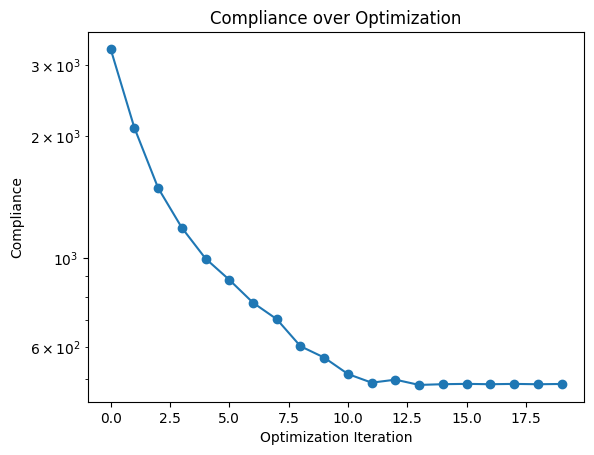

In [19]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [21]:
for i in range(n_steps):
    mesh = hex_mesh
    rho_dot = grad_storage[i + 2000][1][: len(mesh["faces"])]
    pv_mesh = hex_to_pyvista(
        mesh["points"],
        mesh["faces"],
        {"rho": aux_hist[i]["rho_grid"].T.flatten(), "rho_dot": rho_dot.T.flatten()},
    )
    pv_mesh.save(f"tmp_vtks/fem_shapeopt_mesh{i + 1}.vtk")

In [22]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=1).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_bars_optim.gif", writer="pillow", fps=10)